# Leios simulation analysis at tag `leios-2025w26`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: simple variant with conflicts

In [2]:
label <- "Rust simulator, mini-mainnet, 100 tx/s, 0.15 IB/s, 8 slot/stage, 2 MB/IB maximum, 2.5 EB/stage"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/vars/lifecycle.R")) {
    load(file="results/vars/lifecycle.R")
} else {
    lifecycle <- fread("results/vars/lifecycle.csv.gz", stringsAsFactors=TRUE)
    lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
    save(lifecycle, file="results/vars/lifecycle.R")
}
lifecycle %>% summary

 Simulator                        Variant                     Sharding     
 Rust:544698   full                   :181770   overcollateralized:181566  
               full-with-tx-references:181770   sharded           :181566  
               full-without-ibs       :181158   unsharded         :181566  
                                                                           
                                                                           
                                                                           
                                                                           
 Kind             Item           Size [B]         References      
 RB:   498   0      :     9   Min.   :      8   Min.   :  0.0000  
 EB:  3468   1      :     9   1st Qu.:    433   1st Qu.:  0.0000  
 IB:  1110   10     :     9   Median :    931   Median :  1.0000  
 TX:539622   100    :     9   Mean   :   2509   Mean   :  0.9335  
             1000   :     9   3rd Qu.:   1992   3rd Qu.: 

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 1200

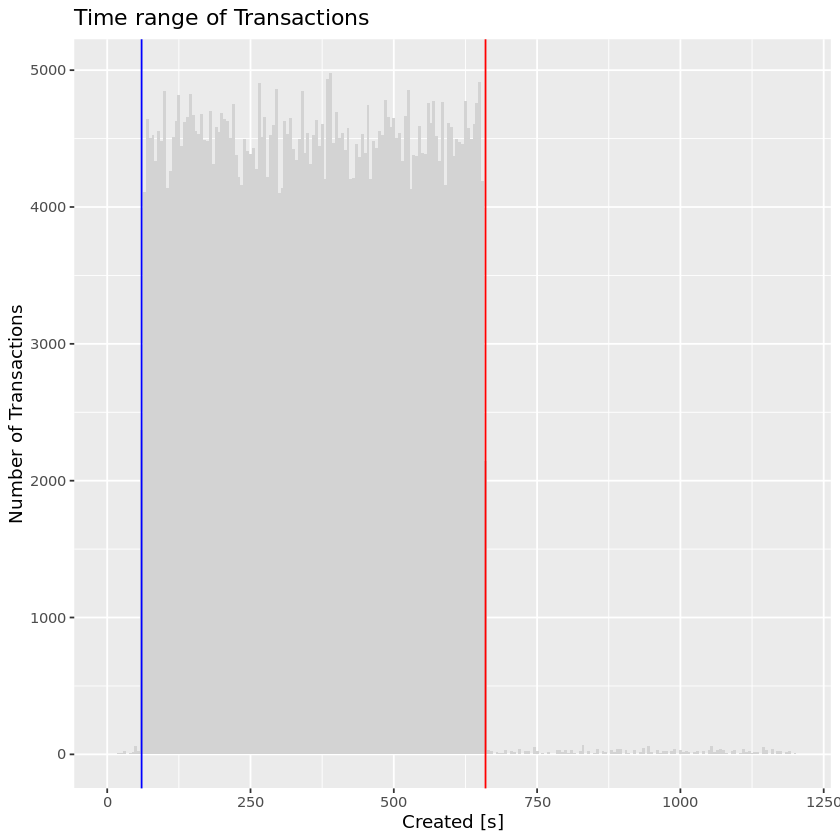

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [IB/s]`=sum(`Size [B]`)/txWindow/1024/2048,
        `Demand [IB]`=sum(`Size [B]`)/txWindow/1024/2048/0.15
    ),
    .(`Variant`, `Sharding`)
]

Variant,Sharding,Demand [tx/s],Demand [MB/s],Demand [IB/s],Demand [IB]
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
full,overcollateralized,99.93,0.1699807,0.08105313,0.5403542
full,sharded,99.93,0.1699807,0.08105313,0.5403542
full,unsharded,99.93,0.1699807,0.08105313,0.5403542
full-without-ibs,overcollateralized,99.93,0.1699807,0.08105313,0.5403542
full-without-ibs,sharded,99.93,0.1699807,0.08105313,0.5403542
full-without-ibs,unsharded,99.93,0.1699807,0.08105313,0.5403542
full-with-tx-references,overcollateralized,99.93,0.1699807,0.08105313,0.5403542
full-with-tx-references,sharded,99.93,0.1699807,0.08105313,0.5403542
full-with-tx-references,unsharded,99.93,0.1699807,0.08105313,0.5403542


#### Size of persisted data

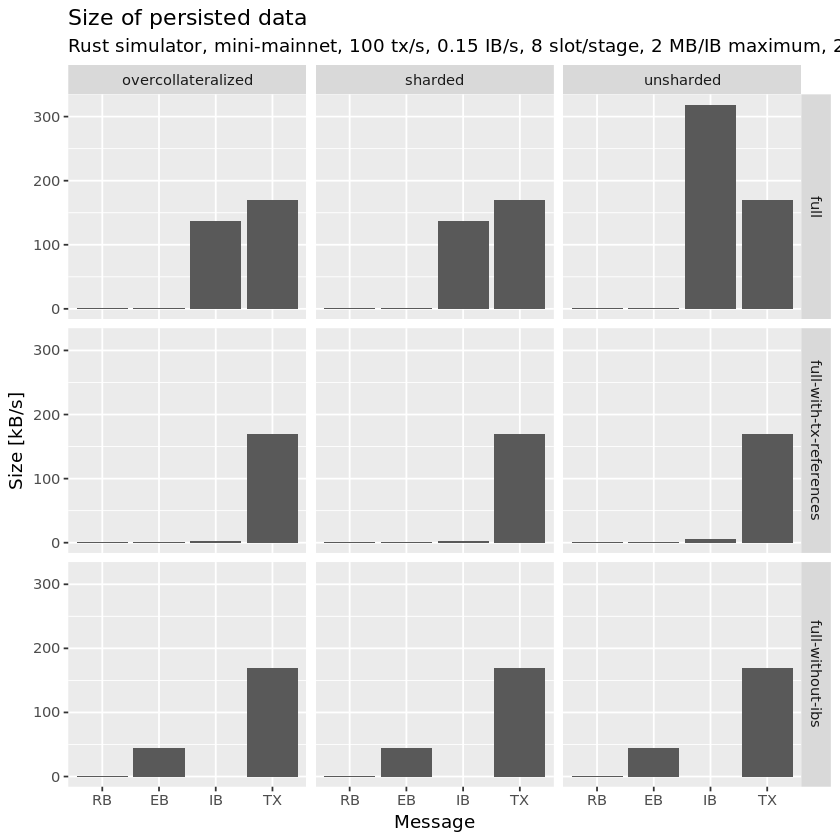

In [7]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Variant`, `Sharding`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_grid(`Variant` ~ `Sharding`, scales="fixed") +
    ggtitle("Size of persisted data", subtitle=label)

In [8]:
ggsave("plots/vars/sizes.png", units="in", dpi=150, width=8, height=6)

In [9]:
ggsave("plots/vars/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

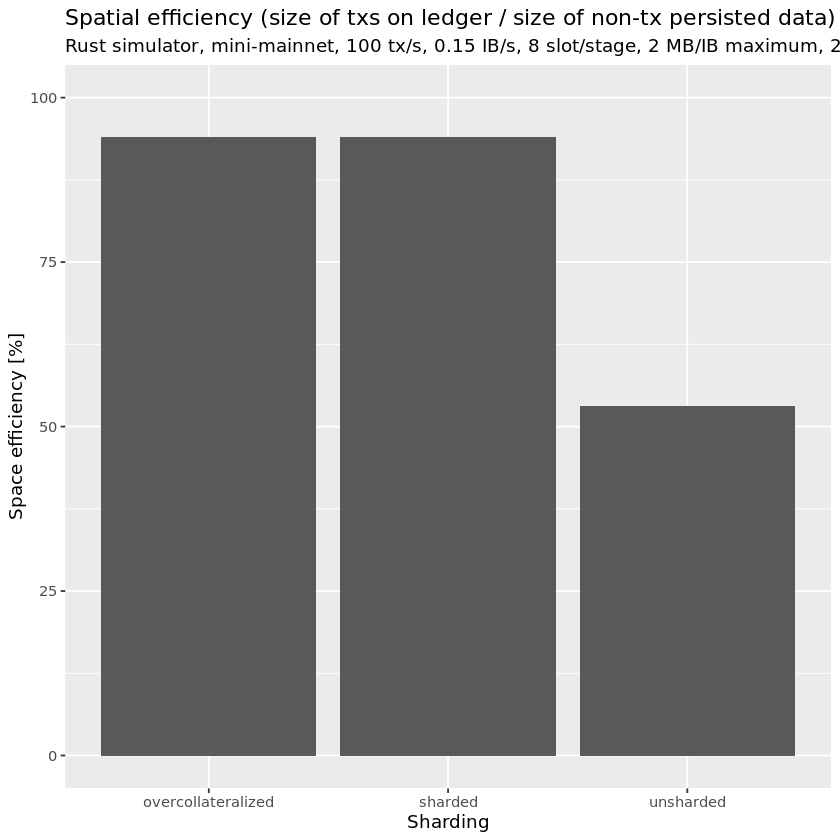

In [10]:
ggplot(
    lifecycle[
        `Variant` == "full" & `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Sharding`)
    ][
        lifecycle[
            `Variant` == "full" & `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Variant`, `Sharding`)
        ],
        on=c("Variant", "Sharding")
    ][, .(`Variant`, `Sharding`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Sharding`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ylim(0, 100) +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [11]:
ggsave("plots/vars/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [12]:
ggsave("plots/vars/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

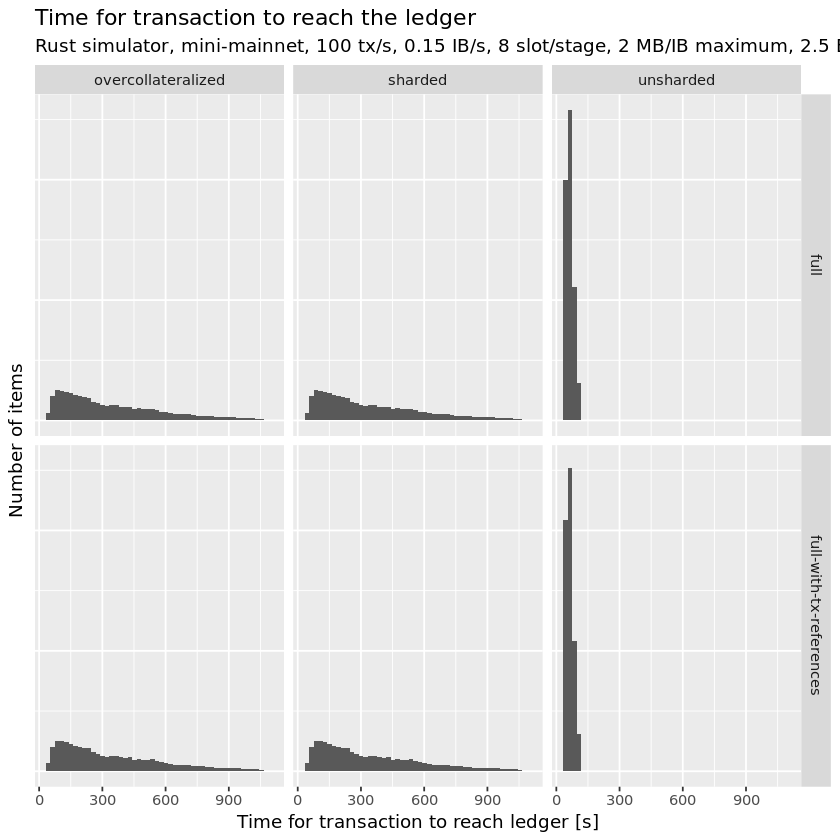

In [13]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Variant`, `Sharding`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_grid(`Variant` ~ `Sharding`, scales="fixed") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [14]:
ggsave("plots/vars/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [15]:
ggsave("plots/vars/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

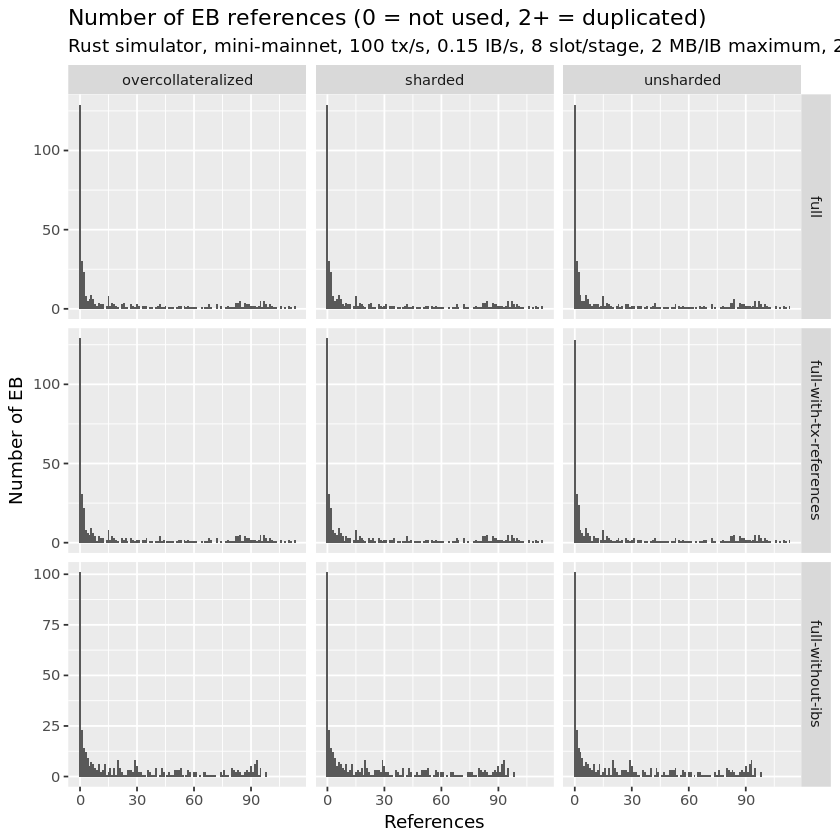

In [16]:
ggplot(
    lifecycle[
        `Kind` == "EB"
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Variant` ~ `Sharding`, scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [17]:
ggsave("plots/vars/references-tx.png", units="in", dpi=150, width=8, height=6)

In [18]:
ggsave("plots/vars/references-tx.svg", units="in", dpi=150, width=8, height=6)

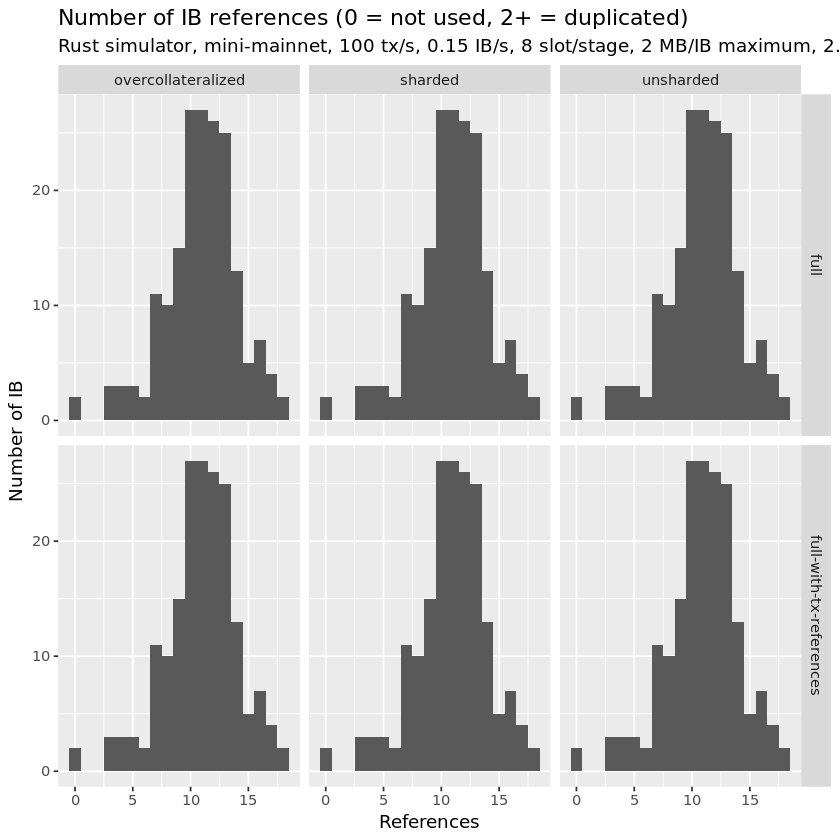

In [19]:
ggplot(
    lifecycle[
        `Kind` == "IB"
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Variant` ~ `Sharding`, scales="free_y") +
    ylab("Number of IB") +
    ggtitle("Number of IB references (0 = not used, 2+ = duplicated)", label)

In [20]:
ggsave("plots/vars/references-ib.png", units="in", dpi=150, width=8, height=6)

In [21]:
ggsave("plots/vars/references-ib.svg", units="in", dpi=150, width=8, height=6)

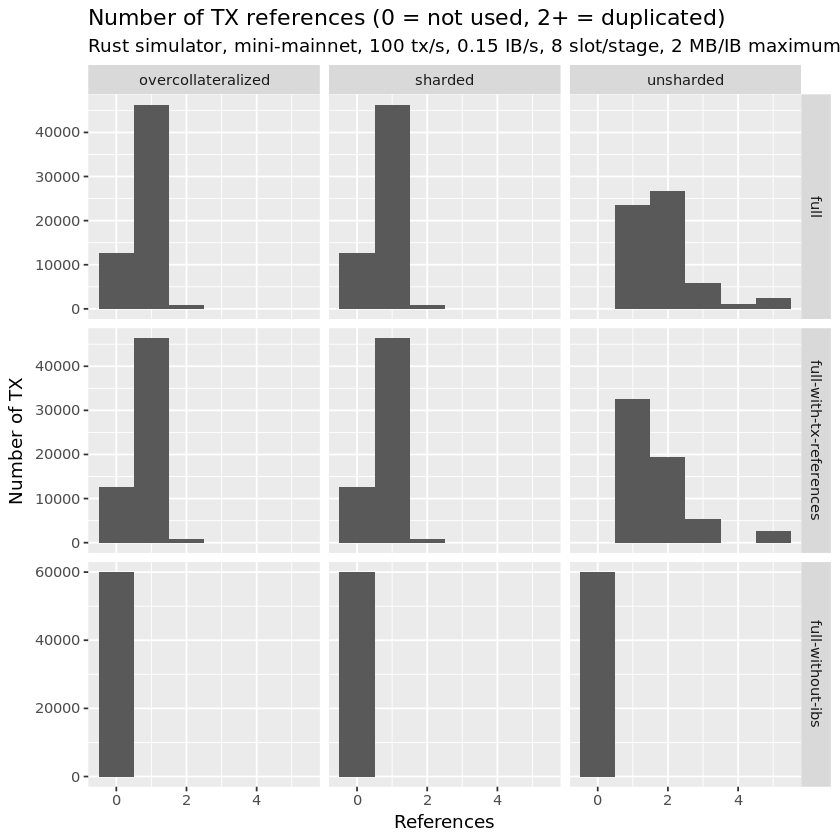

In [22]:
ggplot(
    lifecycle[
        `Kind` == "TX"
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Variant` ~ `Sharding`, scales="free_y") +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [23]:
ggsave("plots/vars/references-tx.png", units="in", dpi=150, width=8, height=6)

In [24]:
ggsave("plots/vars/references-tx.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [25]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [26]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Variant`, `Sharding`
    )
][order(`Variant`, `Sharding`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [27]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Variant`, `Sharding`, `Submitted [minute]`)]

#### Transactions reaching the ledger

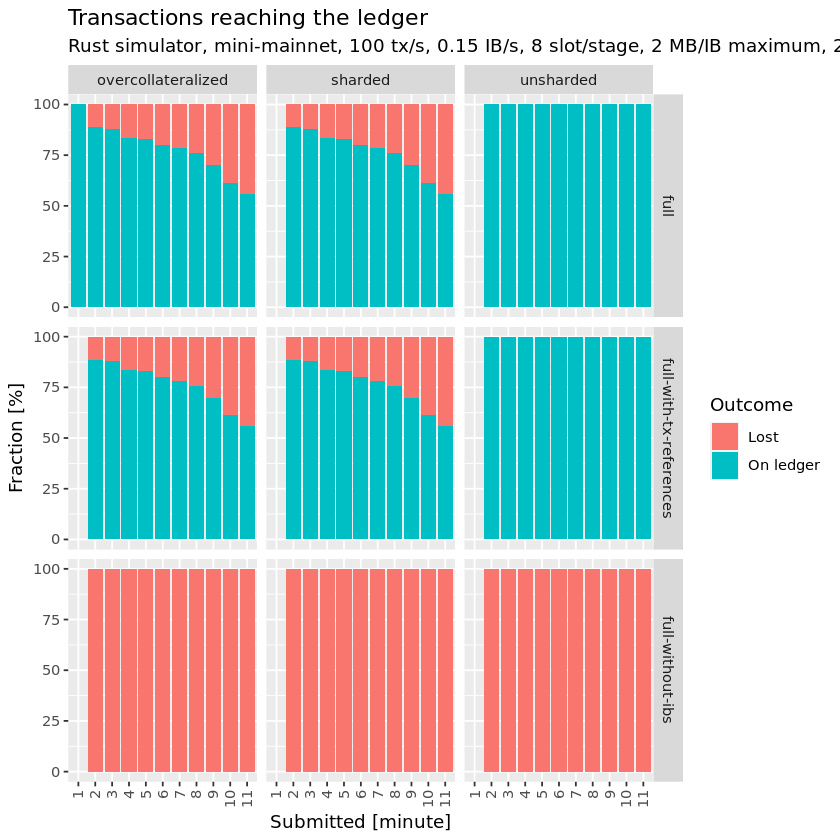

In [28]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Variant`, `Sharding`, `Submitted [minute]`)],
        id.vars=c("Variant", "Sharding", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Variant`, 
        `Sharding`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Variant` ~ `Sharding`) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [29]:
ggsave("plots/vars/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [30]:
ggsave("plots/vars/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


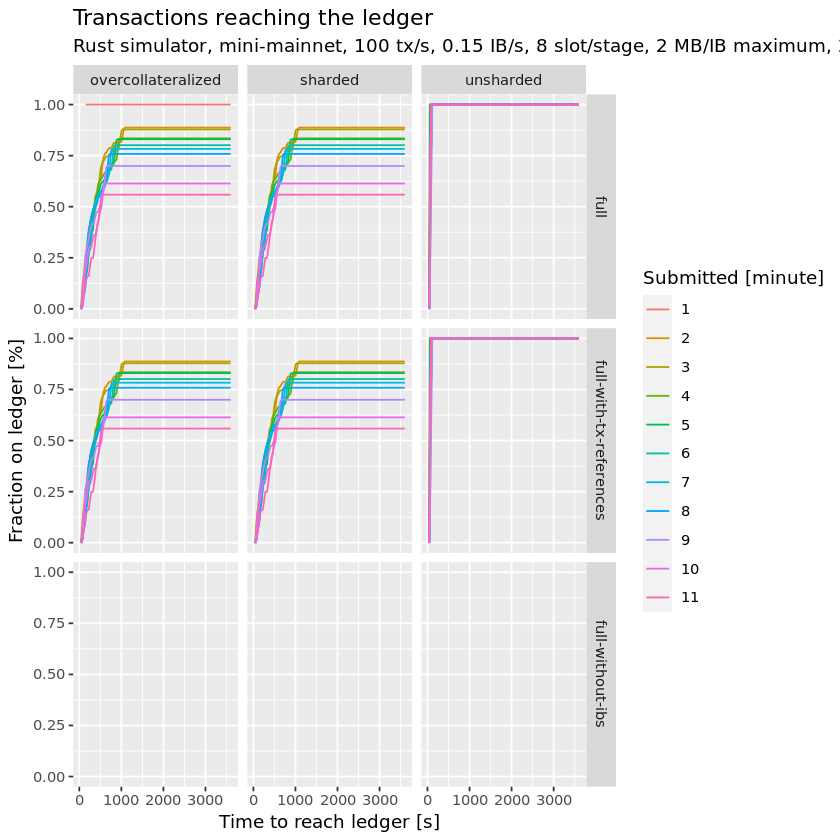

In [31]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Variant`, `Sharding`, `Submitted [minute]`)],
            on=c("Variant", "Sharding", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Variant`, `Sharding`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Variant`, `Sharding`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Variant` ~ `Sharding`) +
    ggtitle("Transactions reaching the ledger", label)

In [32]:
ggsave("plots/vars/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


In [33]:
ggsave("plots/vars/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


#### Release memory

In [34]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [35]:
if (file.exists("results/vars/resources.R")) {
    load(file="results/vars/resources.R")
} else {
    resources <- fread("results/vars/resources.csv.gz", stringsAsFactors=TRUE)
    save(resources, file="results/vars/resources.R")
}
resources %>% summary

 Simulator                      Variant                   Sharding   
 Rust:6750   full                   :2250   overcollateralized:2250  
             full-with-tx-references:2250   sharded           :2250  
             full-without-ibs       :2250   unsharded         :2250  
                                                                     
                                                                     
                                                                     
                                                                     
       Node        Egress [B]           Disk [B]       Total CPU [s]  
 node-0  :   9   Min.   :2.663e+05   Min.   :      0   Min.   :156.2  
 node-1  :   9   1st Qu.:7.923e+06   1st Qu.:      0   1st Qu.:156.8  
 node-10 :   9   Median :8.746e+07   Median :      0   Median :210.9  
 node-100:   9   Mean   :1.500e+08   Mean   :  66480   Mean   :204.1  
 node-101:   9   3rd Qu.:2.123e+08   3rd Qu.:   1296   3rd Qu.:211.8  
 node-102:   9

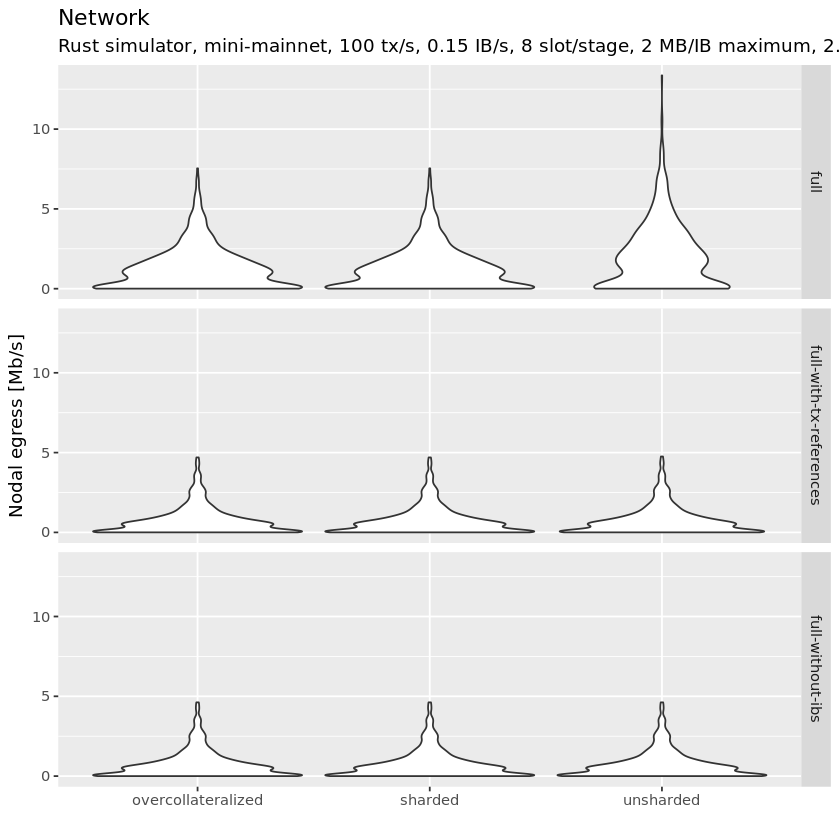

In [36]:
ggplot(
    resources[, .(`Variant`, `Sharding`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Sharding`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`Variant` ~ .) +
    xlab("") +
    ggtitle("Network", label)

In [37]:
ggsave("plots/vars/network.png", units="in", dpi=150, width=9.5, height=5.5)

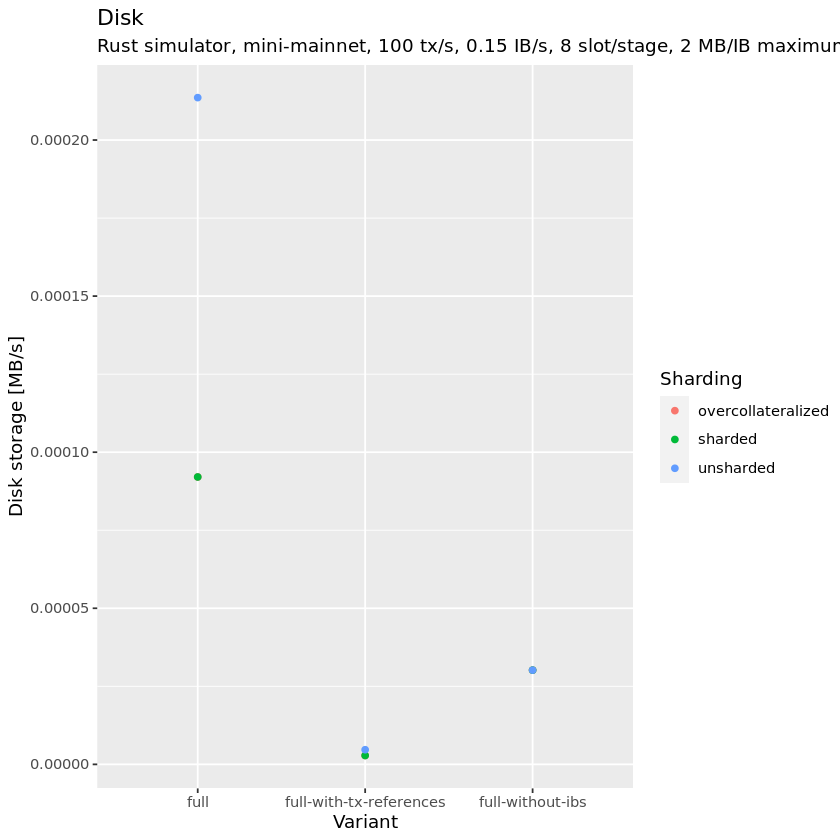

In [38]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Variant`, `Sharding`)],
    aes(x=`Variant`, color=`Sharding`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [39]:
ggsave("plots/vars/disk.png", units="in", dpi=150, width=9.5, height=5.5)

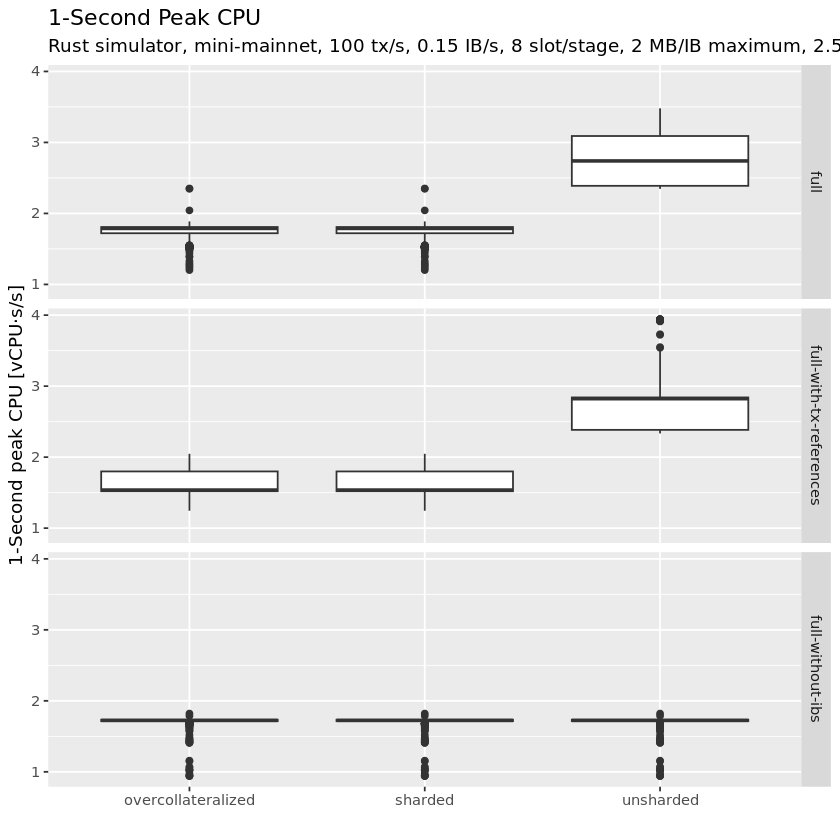

In [40]:
ggplot(
    resources[, .(`Node`, `Variant`, `Sharding`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Sharding`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    facet_grid(`Variant` ~ .) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [41]:
ggsave("plots/vars/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

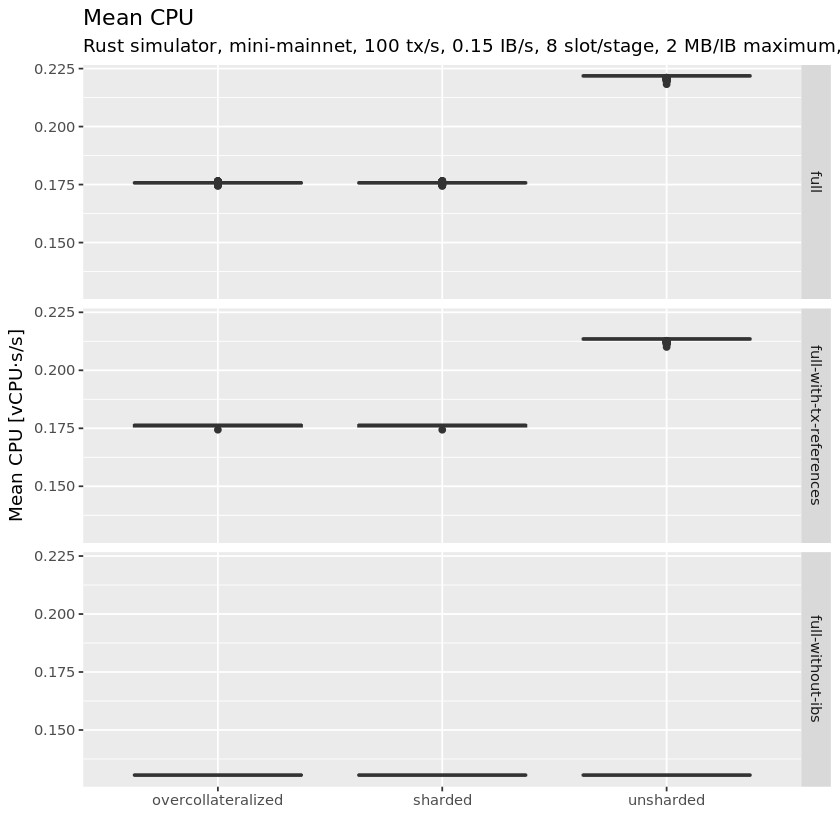

In [42]:
ggplot(
    resources[, .(`Variant`, `Sharding`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Sharding`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    facet_grid(`Variant` ~ .) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [43]:
ggsave("plots/vars/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [44]:
rm(resources)

### Receipt of messages

#### Read results

In [45]:
if (file.exists("results/vars/receipts.R")) {
    load("results/vars/receipts.R")
} else {
    receipts <- fread("results/vars/receipts.csv.gz", stringsAsFactors=TRUE)
    save(receipts, file="results/vars/receipts.R")
}
receipts %>% summary

 Simulator                           Variant         
 Rust:583305297   full                   :194601797  
                  full-with-tx-references:194602771  
                  full-without-ibs       :194100729  
                                                     
                                                     
                                                     
                                                     
               Sharding         Kind                      Item          
 overcollateralized:194434806   EB:  2597532   376-node-60  :    13482  
 sharded           :194434806   IB:   829284   400-node-181 :    13482  
 unsharded         :194435685   RB:   365946   1000-node-18 :    11235  
                                TX:404176878   1000-node-197:    11235  
                                VT:175335657   1000-node-590:    11235  
                                               1008-node-147:    11235  
                                               (Other)   

In [46]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [47]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Variant`, `Sharding`, `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

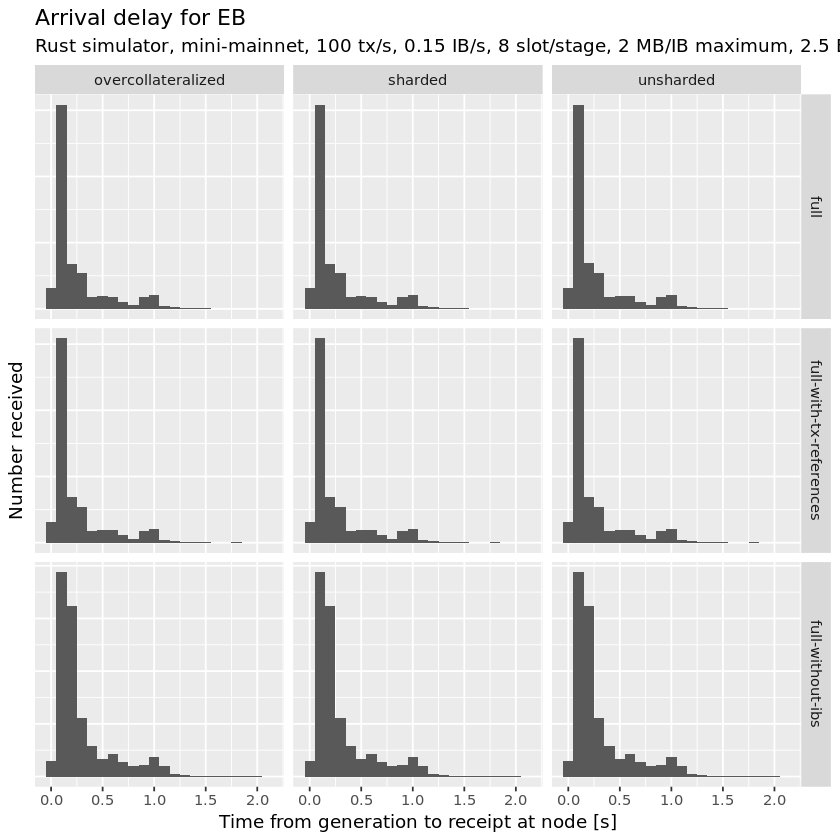

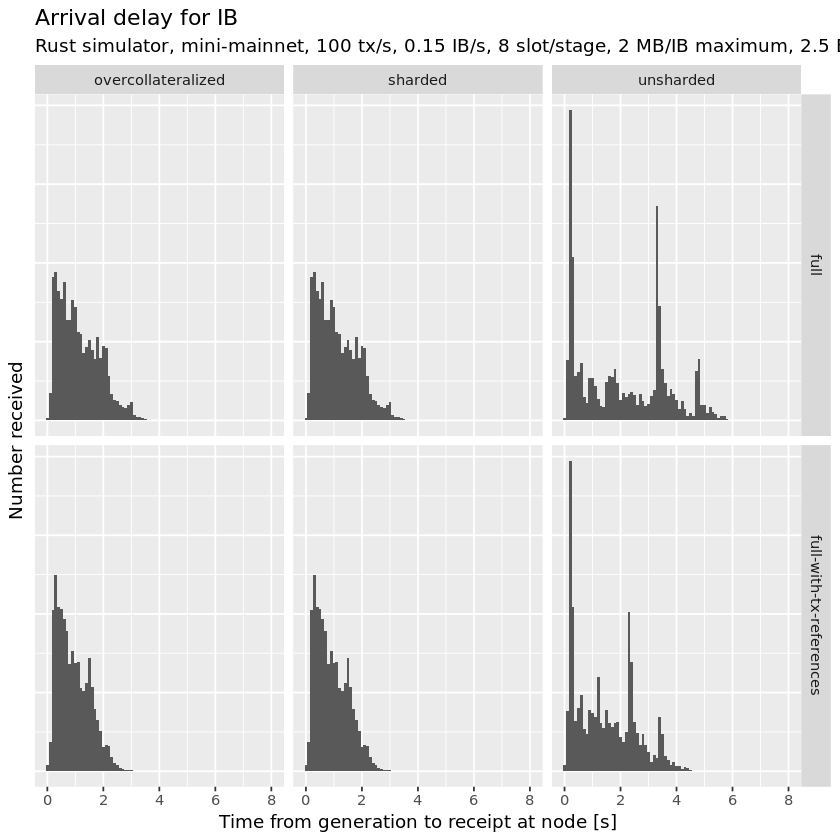

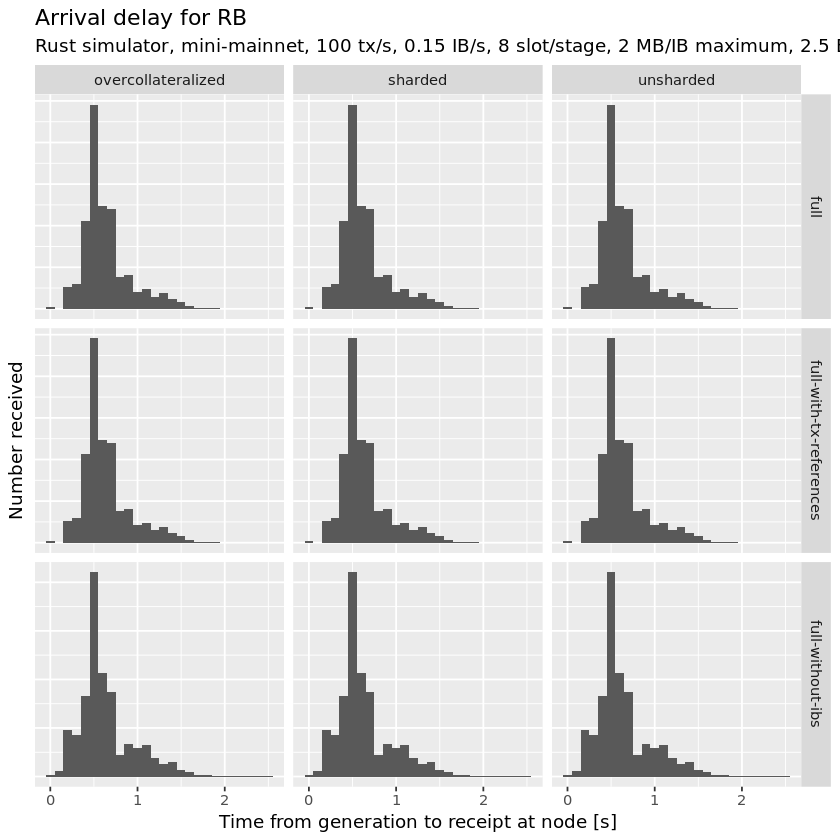

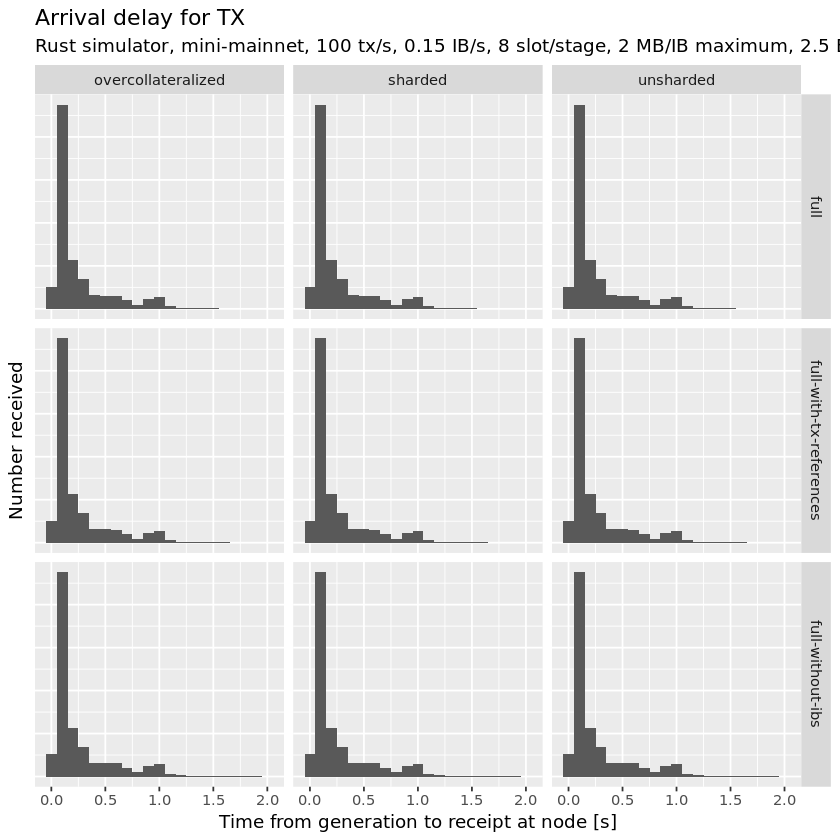

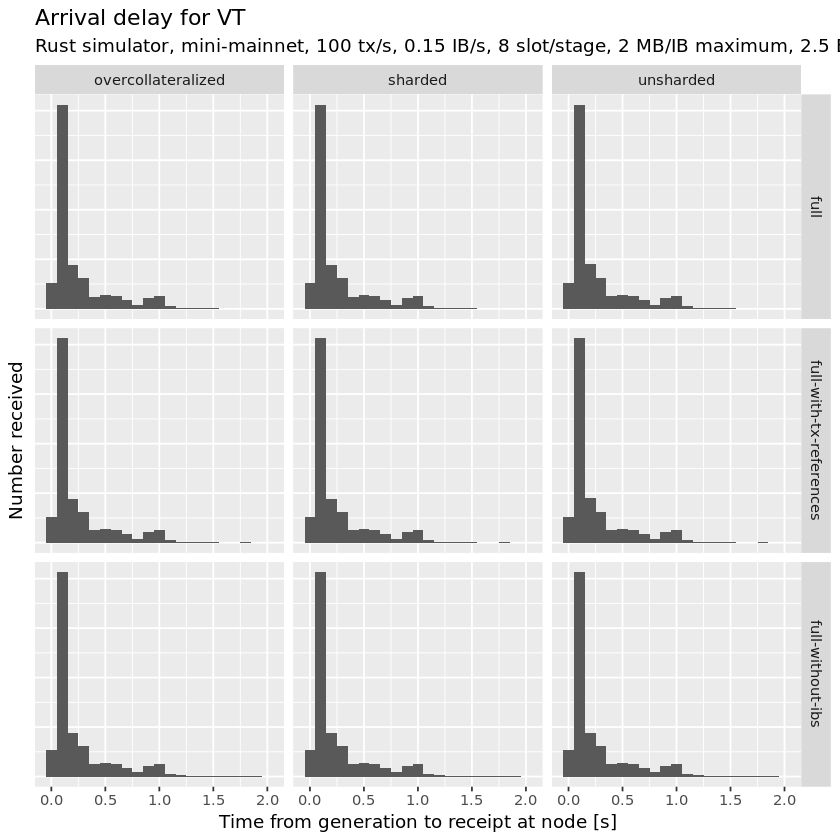

In [48]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/vars/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [49]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Variant`, `Sharding`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Variant`, `Sharding`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Variant`, `Sharding`, `Generated [s]`)
        ][, .(`Variant`, `Sharding`, `Generated [s]`,`Received`)
        ], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Variant`  ~ `Sharding`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

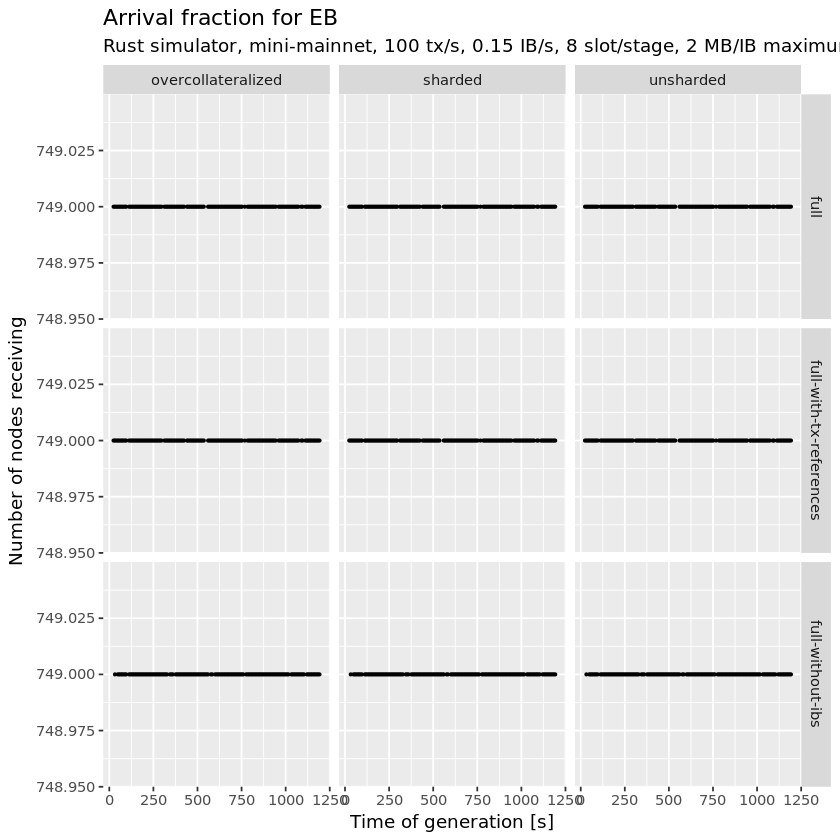

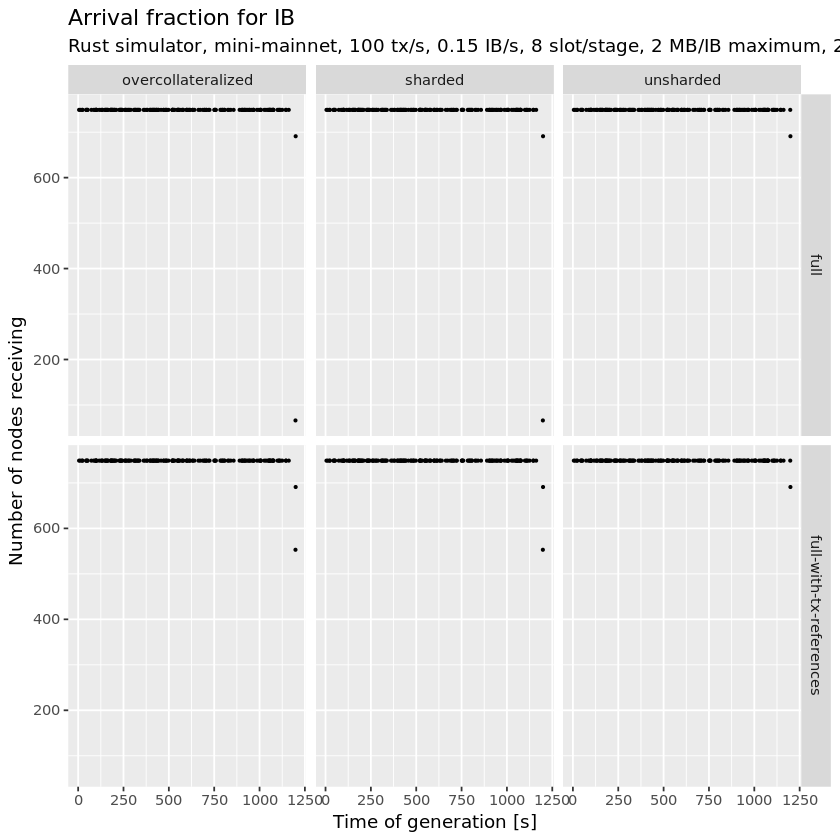

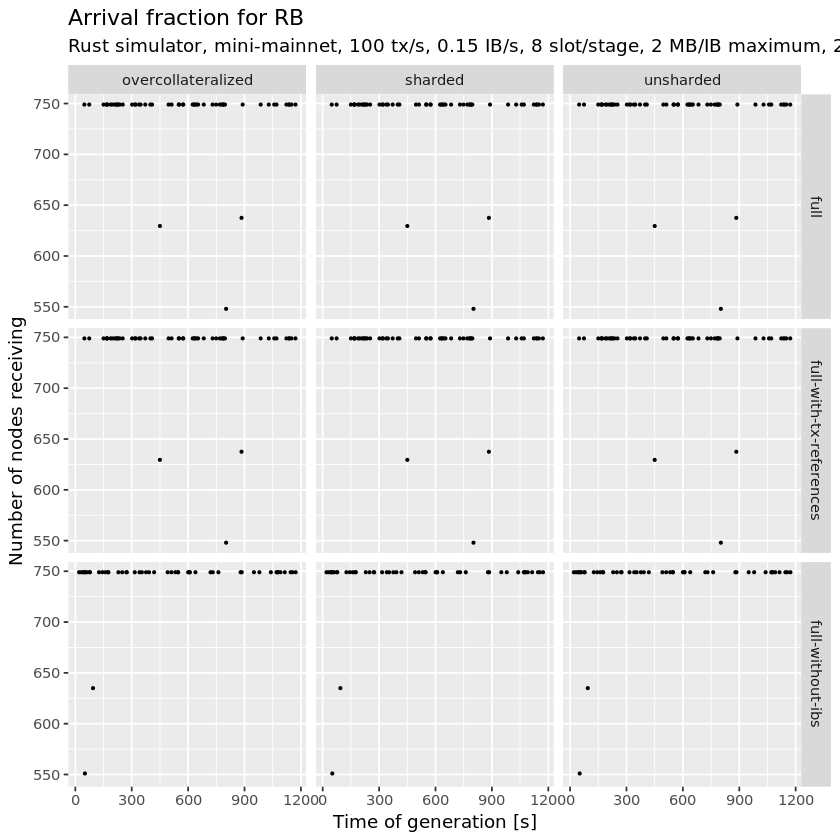

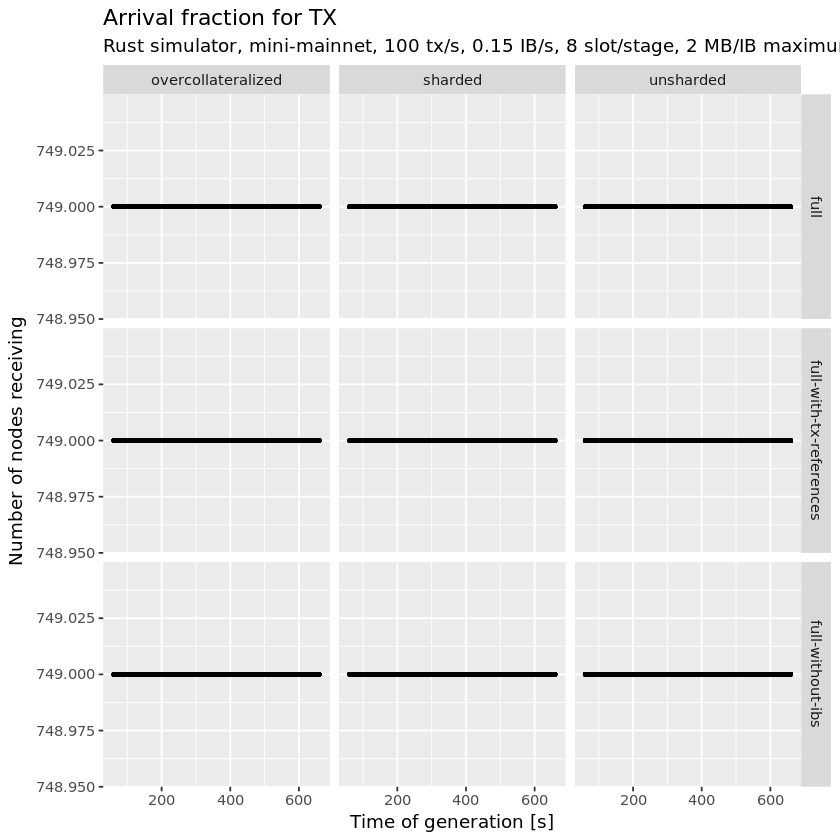

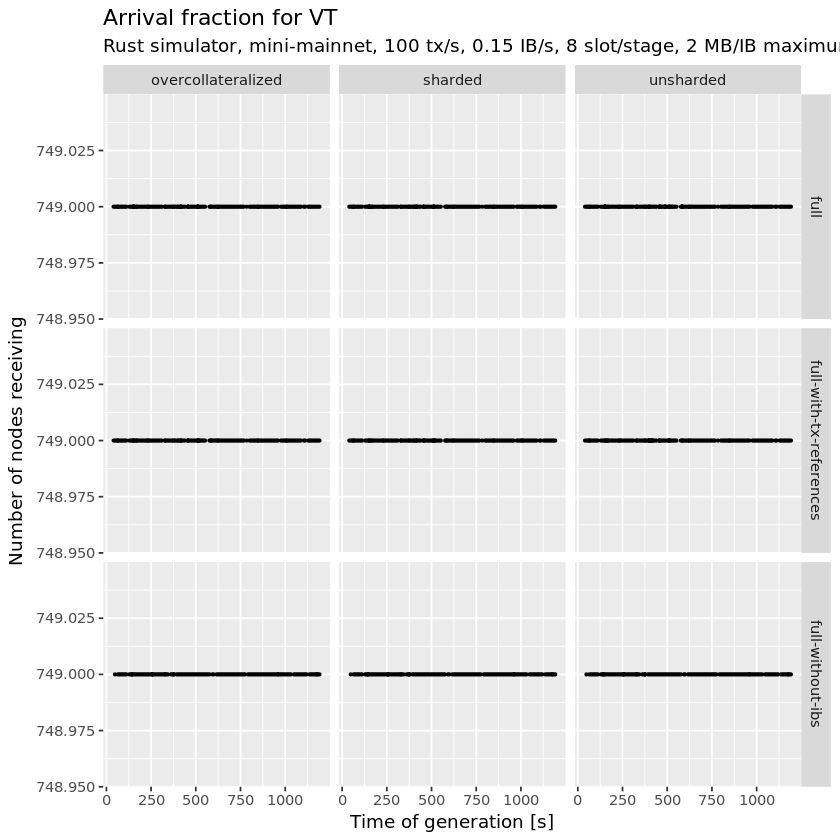

In [50]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/vars/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [51]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Variant`,
                `Sharding`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

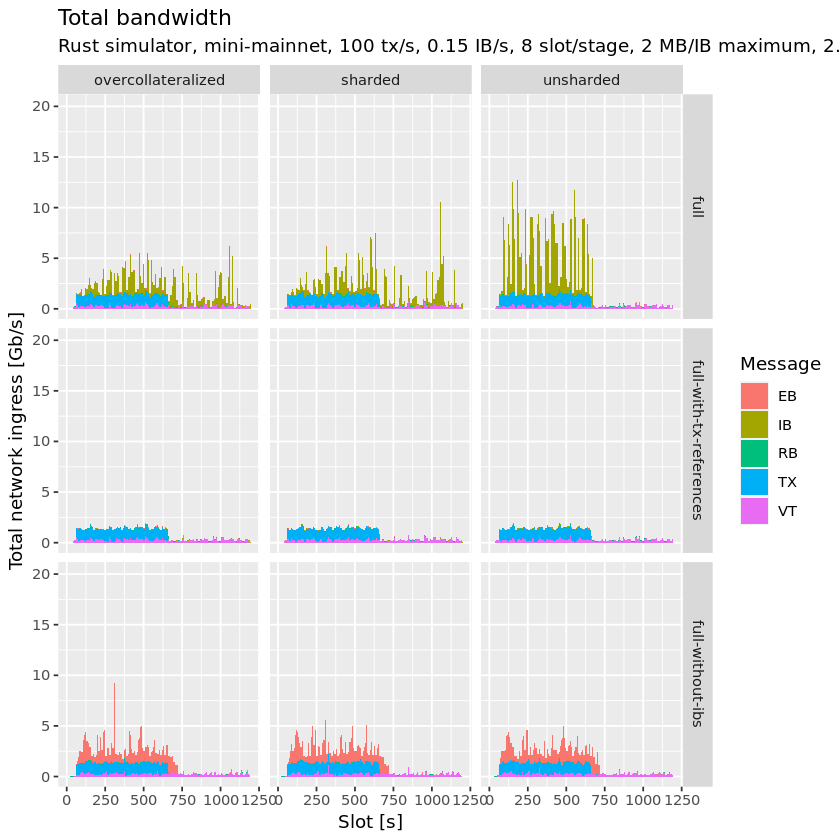

In [52]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/vars/ingress-total-area.png")
)

##### Bandwidth usage per node

In [53]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [54]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Variant`,
                `Sharding`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

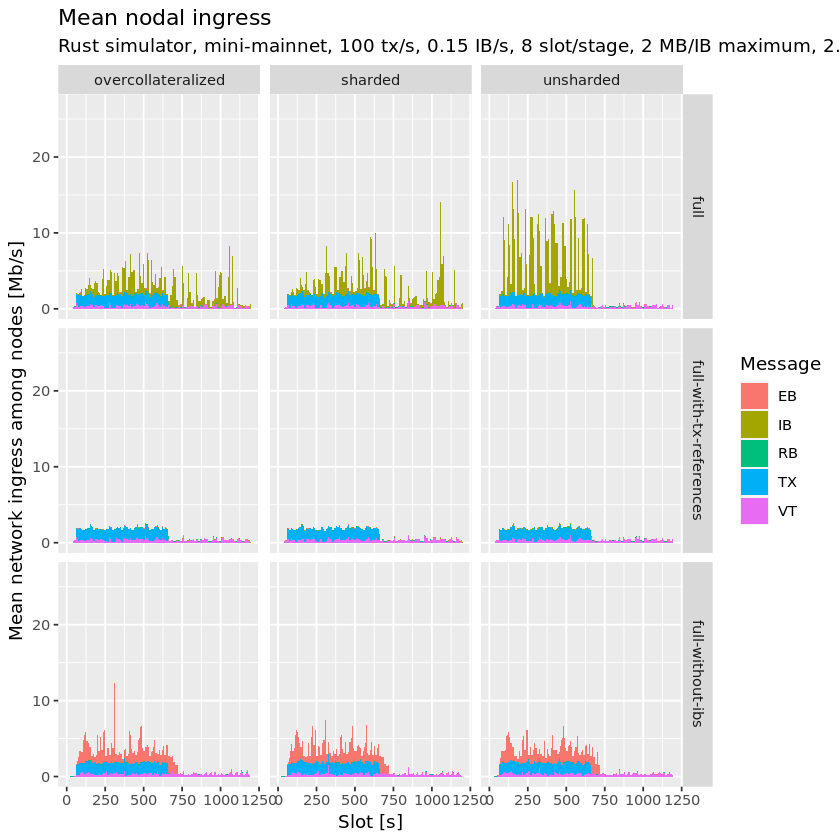

In [55]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/vars/ingress-average-area.png")
)

In [56]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Variant`,
                `Sharding`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Variant`, `Sharding`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

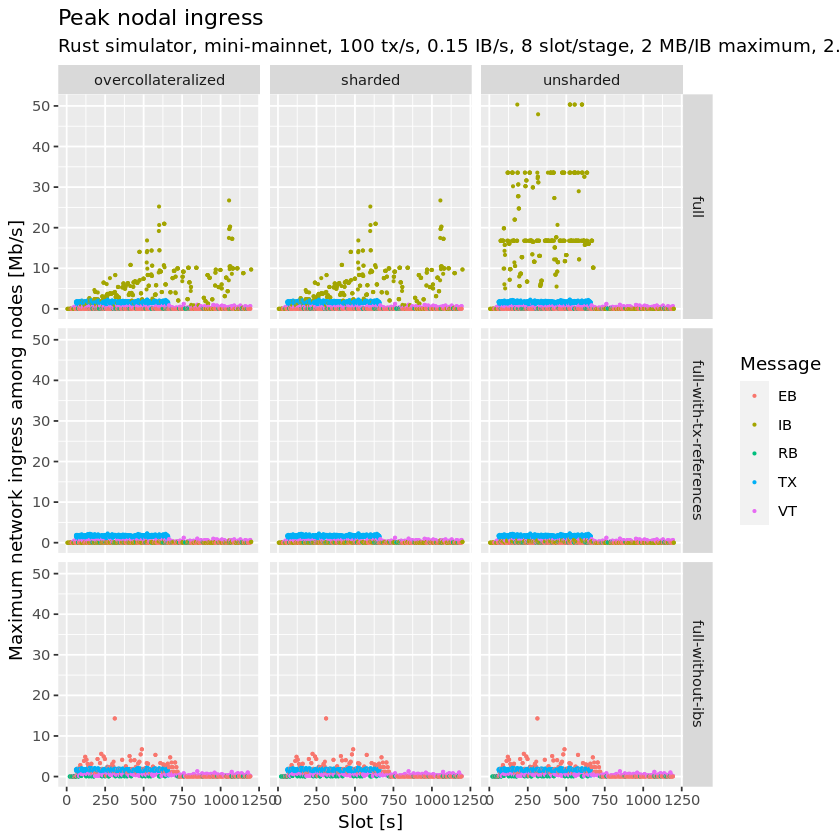

In [57]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/vars/ingress-peak-point.png")
)

#### Release memory

In [58]:
rm(receipts)

### CPU usage

#### Read results

In [59]:
if (file.exists("results/vars/cpus.R")) {
    load(file="results/vars/cpus.R")
} else {
    cpus <- fread("results/vars/cpus.csv.gz", stringsAsFactors=TRUE)
    save(cpus, file="results/vars/cpus.R")
}
cpus %>% summary

 Simulator                           Variant         
 Rust:904438597   full                   :304391359  
                  full-with-tx-references:304392154  
                  full-without-ibs       :295655084  
                                                     
                                                     
                                                     
                                                     
               Sharding              Slot              Node          
 overcollateralized:301479332   Min.   :   5.0   node-508:  1206190  
 sharded           :301479182   1st Qu.: 256.0   node-602:  1206160  
 unsharded         :301480083   Median : 461.0   node-495:  1206136  
                                Mean   : 500.7   node-286:  1206115  
                                3rd Qu.: 656.0   node-198:  1206111  
                                Max.   :1200.0   node-246:  1206097  
                                                 (Other) :897201788  
      Ta

In [60]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Variant`, `Sharding`, `Node`, `Slot`)
]

#### Peak CPU usage

##### Histogram

In [61]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Variant`, `Sharding`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

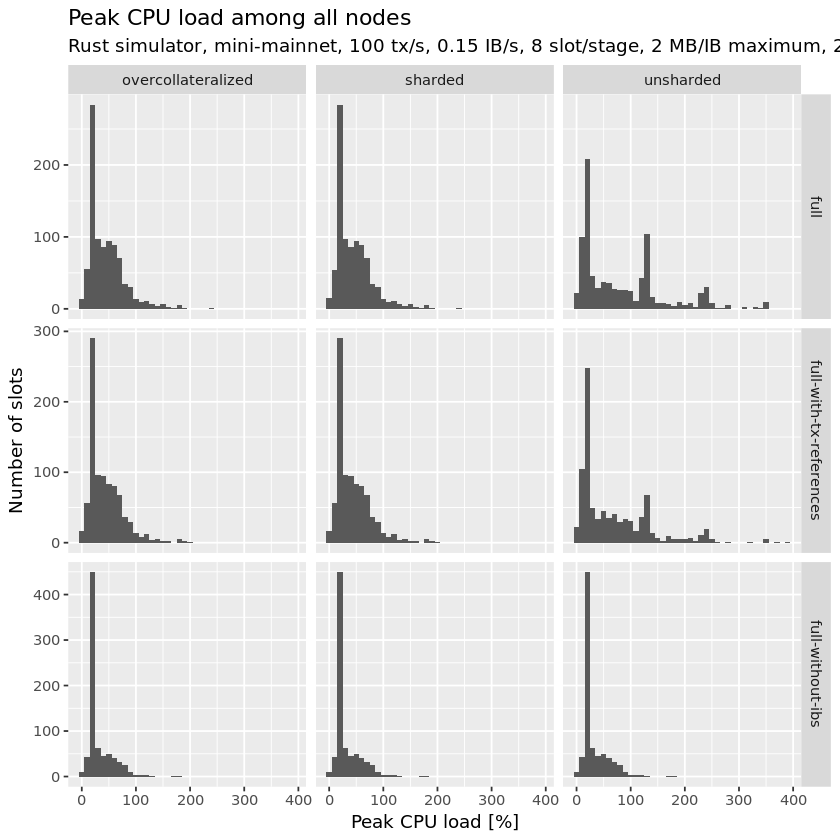

In [62]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/vars/cpu-peak-histogram.png")
)

##### Time series

In [63]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)),
            by=.(`Variant`, `Sharding`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Variant` ~ `Sharding`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

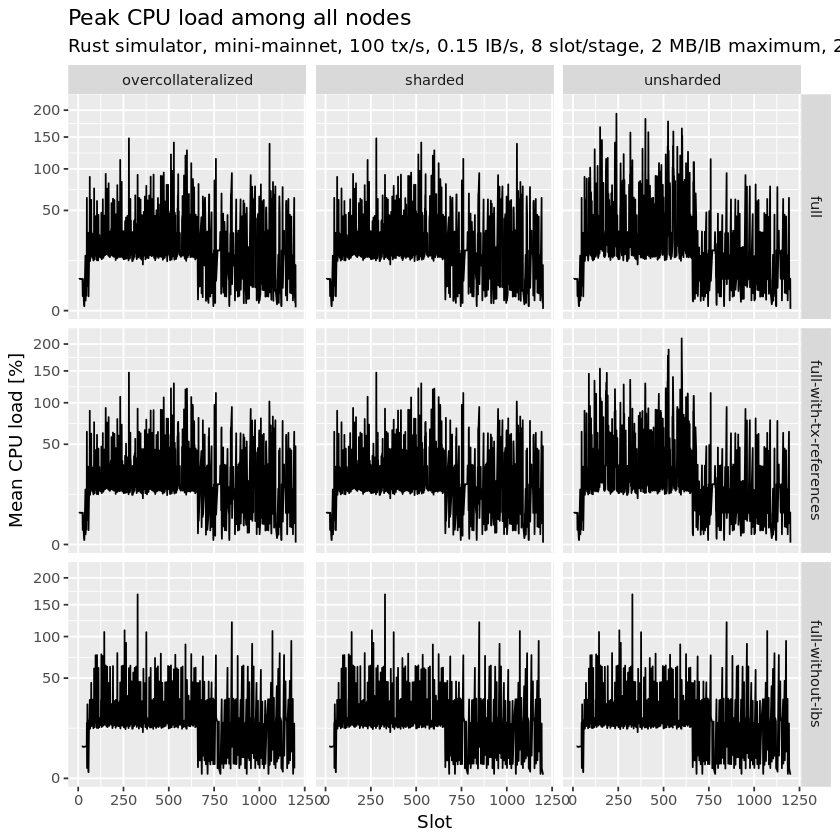

In [64]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/vars/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [65]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Sharding`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

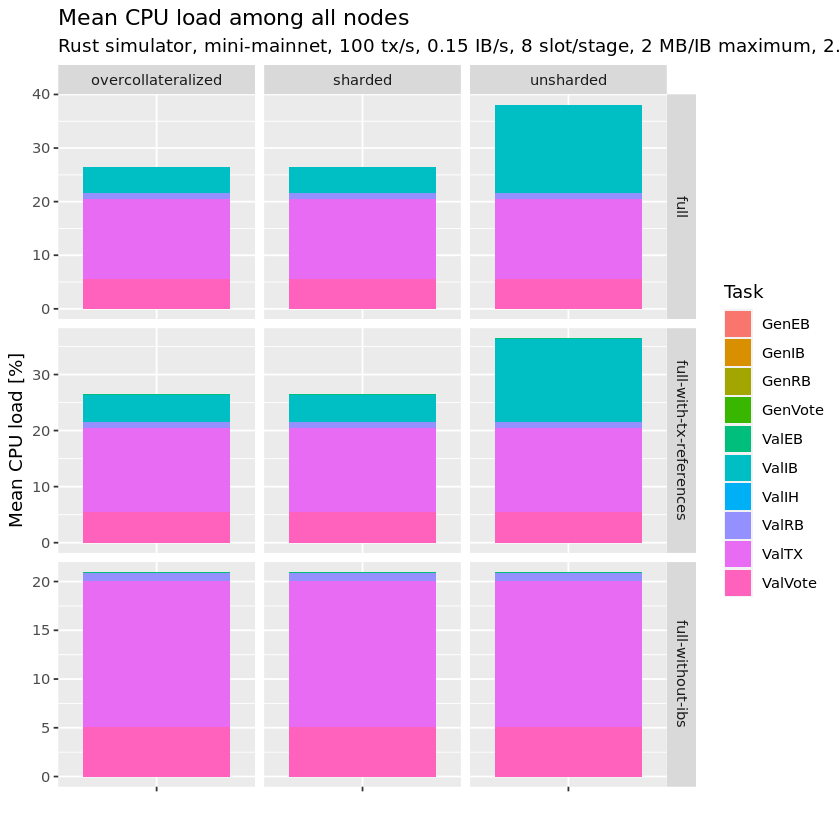

In [66]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/vars/cpu-mean-histogram.png")
)

##### Time series

In [67]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Sharding`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

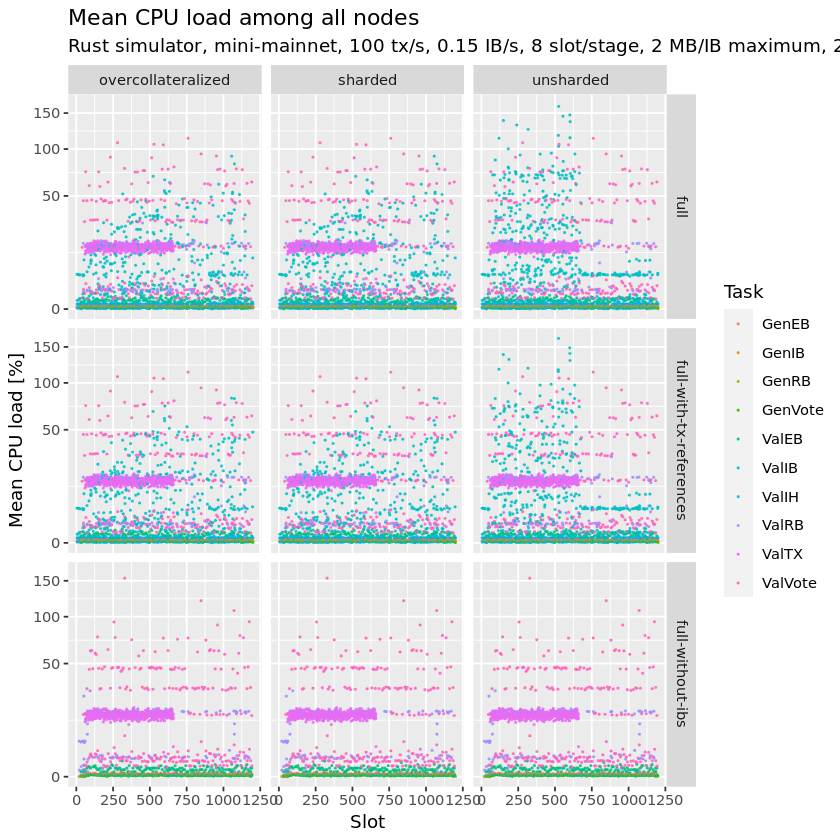

In [68]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/vars/cpu-mean-timeseries.png")
)

#### Release memory

In [69]:
rm(cpus, cpusNode)